# False Positive Brand Classifier - Model Selection & Tuning

This notebook performs model selection and hyperparameter tuning for the FP classifier. It loads the feature transformer created in fp1_EDA_FE.ipynb and focuses on finding the optimal model.

## Objective
Select the best classification model and tune hyperparameters to maximize F2 score (recall-weighted).

## Contents
1. [Setup](#setup)
2. [Data Loading & Split](#1-data-loading--split)
3. [Feature Transformation](#2-feature-transformation)
4. [Baseline Model Comparison](#3-baseline-model-comparison)
5. [Hyperparameter Tuning](#4-hyperparameter-tuning)
6. [Overfitting Analysis](#5-overfitting-analysis)
7. [Final Model & Threshold Selection](#6-final-model--threshold-selection)
8. [Export for Deployment](#7-export-for-deployment)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns

# Sklearn imports
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    fbeta_score, make_scorer, precision_recall_curve,
    classification_report, confusion_matrix
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import load_jsonl_data, split_train_val_test
from src.fp1_nb.preprocessing import clean_text, create_text_features
from src.fp1_nb.feature_transformer import FPFeatureTransformer
from src.fp1_nb.modeling import (
    create_search_object,
    tune_with_logging,
    get_best_params_summary,
    get_best_model,
    compare_models,
    evaluate_model,
    compare_val_test_performance,
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TARGET_COL = 'is_sportswear'
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

print("Setup complete!")

Setup complete!


## 1. Data Loading & Split

Load data and apply identical preprocessing and split as fp1 to ensure consistency.

In [2]:
# Load the FP training data (same as fp1)
df = load_jsonl_data(DATA_PATH)

# Create combined text features (identical to fp1)
# This ensures we use the same preprocessing
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    clean_func=clean_text
)

print(f"\nText features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

Loaded 971 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 6.78 MB



Text features created!
Sample:
mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date salomon ever since their debut collaboration in 2022 featuring the rihanna approved cross low model mm6 maison margiela and salomon have been frequent partners tweaking...


In [3]:
# Split with stratification (identical to fp1 - same random_state ensures identical splits)
train_df, val_df, test_df = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=RANDOM_STATE
)

TRAIN/VALIDATION/TEST SPLIT

Total samples: 971

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      582 (59.9%)
  Validation: 194 (20.0%)
  Test:       195 (20.1%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 86.6%, 0: 13.4%
  Val: 1: 86.6%, 0: 13.4%
  Test: 1: 86.7%, 0: 13.3%


## 2. Feature Transformation

Load the fitted feature transformer from fp1 and transform all splits.

In [4]:
# Load the fitted feature transformer from fp1
transformer_path = MODELS_DIR / 'fp_feature_transformer.joblib'
transformer = joblib.load(transformer_path)

# Load the transformer config
config_path = MODELS_DIR / 'fp_feature_config.json'
with open(config_path) as f:
    transformer_config = json.load(f)

print(f"Loaded transformer: {transformer}")
print(f"\nTransformer config:")
for key, value in transformer_config.items():
    print(f"  {key}: {value}")

Loaded transformer: FPFeatureTransformer(method='sentence_transformer_ner', max_features=10000, fitted=True)

Transformer config:
  method: sentence_transformer_ner
  max_features: 10000
  ngram_range: [1, 2]
  min_df: 2
  max_df: 0.95
  sublinear_tf: True
  norm: l2
  char_ngram_range: [3, 5]
  char_max_features: 5000
  lsa_n_components: 100
  context_window_words: 20
  doc2vec_vector_size: 100
  doc2vec_min_count: 2
  doc2vec_epochs: 40
  doc2vec_dm: 1
  doc2vec_window: 4
  sentence_model_name: all-MiniLM-L6-v2
  include_vocab_features: True
  vocab_window_size: 15
  proximity_window_size: 15
  random_state: 42


In [5]:
# Transform all splits using the fitted transformer
X_train = transformer.transform(train_df['text_features'])
X_val = transformer.transform(val_df['text_features'])
X_test = transformer.transform(test_df['text_features'])

# Extract targets
y_train = train_df[TARGET_COL].values
y_val = val_df[TARGET_COL].values
y_test = test_df[TARGET_COL].values

# Combine train+val for hyperparameter tuning
if sp.issparse(X_train):
    X_trainval = sp.vstack([X_train, X_val])
else:
    X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

print(f"Feature dimensionality: {X_train.shape[1]}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_trainval shape: {X_trainval.shape} (for hyperparameter tuning)")

Feature dimensionality: 390
X_train shape: (582, 390)
X_val shape: (194, 390)
X_test shape: (195, 390)
X_trainval shape: (776, 390) (for hyperparameter tuning)


## 3. Baseline Model Comparison

Train and evaluate multiple classifiers on the transformed features to identify the best performing models for hyperparameter tuning.

In [6]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
print(f"Using {N_FOLDS}-fold stratified CV")

# F2 scorer (weights recall 2x higher than precision)
f2_scorer = make_scorer(fbeta_score, beta=2)

Using 3-fold stratified CV


In [7]:
# Define baseline models
# Note: MultinomialNB not included as it requires non-negative features
# (sentence transformer embeddings contain negative values)
baseline_models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ),
    'Linear SVM': CalibratedClassifierCV(
        LinearSVC(max_iter=2000, random_state=RANDOM_STATE, class_weight='balanced'),
        cv=3
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    ),
    'HistGradientBoosting': HistGradientBoostingClassifier(
        max_iter=100,
        max_depth=5,
        class_weight='balanced',
        random_state=RANDOM_STATE,
    ),
}

In [8]:
# Train and evaluate baseline models
baseline_results = []

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    metrics = evaluate_model(
        model, X_val, y_val,
        model_name=name,
        dataset_name='Validation',
        verbose=True,
        plot=False
    )
    
    # Add F2 score to metrics (recall-weighted)
    y_pred = model.predict(X_val)
    metrics['f2'] = fbeta_score(y_val, y_pred, beta=2)
    print(f"  F2 Score:  {metrics['f2']:.4f} (recall-weighted)")
    
    baseline_results.append(metrics)


Training Logistic Regression...

MODEL EVALUATION: Logistic Regression on Validation

Classification Metrics:
  Accuracy:  0.9330
  Precision: 1.0000
  Recall:    0.9226
  F1 Score:  0.9598
  ROC-AUC:   0.9819
  PR-AUC:    0.9973

Confusion Matrix:
  TN: 26  FP: 0
  FN: 13  TP: 155

                precision    recall  f1-score   support

Not Sportswear       0.67      1.00      0.80        26
    Sportswear       1.00      0.92      0.96       168

      accuracy                           0.93       194
     macro avg       0.83      0.96      0.88       194
  weighted avg       0.96      0.93      0.94       194

  F2 Score:  0.9371 (recall-weighted)

Training Linear SVM...



MODEL EVALUATION: Linear SVM on Validation

Classification Metrics:
  Accuracy:  0.9485
  Precision: 0.9647
  Recall:    0.9762
  F1 Score:  0.9704
  ROC-AUC:   0.9888
  PR-AUC:    0.9983

Confusion Matrix:
  TN: 20  FP: 6
  FN: 4  TP: 164

                precision    recall  f1-score   support

Not Sportswear       0.83      0.77      0.80        26
    Sportswear       0.96      0.98      0.97       168

      accuracy                           0.95       194
     macro avg       0.90      0.87      0.89       194
  weighted avg       0.95      0.95      0.95       194

  F2 Score:  0.9739 (recall-weighted)

Training Random Forest...



MODEL EVALUATION: Random Forest on Validation

Classification Metrics:
  Accuracy:  0.9021
  Precision: 0.9071
  Recall:    0.9881
  F1 Score:  0.9459
  ROC-AUC:   0.9761
  PR-AUC:    0.9964

Confusion Matrix:
  TN: 9  FP: 17
  FN: 2  TP: 166

                precision    recall  f1-score   support

Not Sportswear       0.82      0.35      0.49        26
    Sportswear       0.91      0.99      0.95       168

      accuracy                           0.90       194
     macro avg       0.86      0.67      0.72       194
  weighted avg       0.90      0.90      0.88       194

  F2 Score:  0.9708 (recall-weighted)

Training HistGradientBoosting...



MODEL EVALUATION: HistGradientBoosting on Validation

Classification Metrics:
  Accuracy:  0.9433
  Precision: 0.9645
  Recall:    0.9702
  F1 Score:  0.9674
  ROC-AUC:   0.9794
  PR-AUC:    0.9970

Confusion Matrix:
  TN: 20  FP: 6
  FN: 5  TP: 163

                precision    recall  f1-score   support

Not Sportswear       0.80      0.77      0.78        26
    Sportswear       0.96      0.97      0.97       168

      accuracy                           0.94       194
     macro avg       0.88      0.87      0.88       194
  weighted avg       0.94      0.94      0.94       194

  F2 Score:  0.9691 (recall-weighted)



Baseline Model Comparison (Validation Set)
                          f2  recall  precision      f1  accuracy  pr_auc
model_name                                                               
Logistic Regression   0.9371  0.9226     1.0000  0.9598    0.9330  0.9973
Linear SVM            0.9739  0.9762     0.9647  0.9704    0.9485  0.9983
Random Forest         0.9708  0.9881     0.9071  0.9459    0.9021  0.9964
HistGradientBoosting  0.9691  0.9702     0.9645  0.9674    0.9433  0.9970



Figure saved to images/fp_baseline_comparison.png


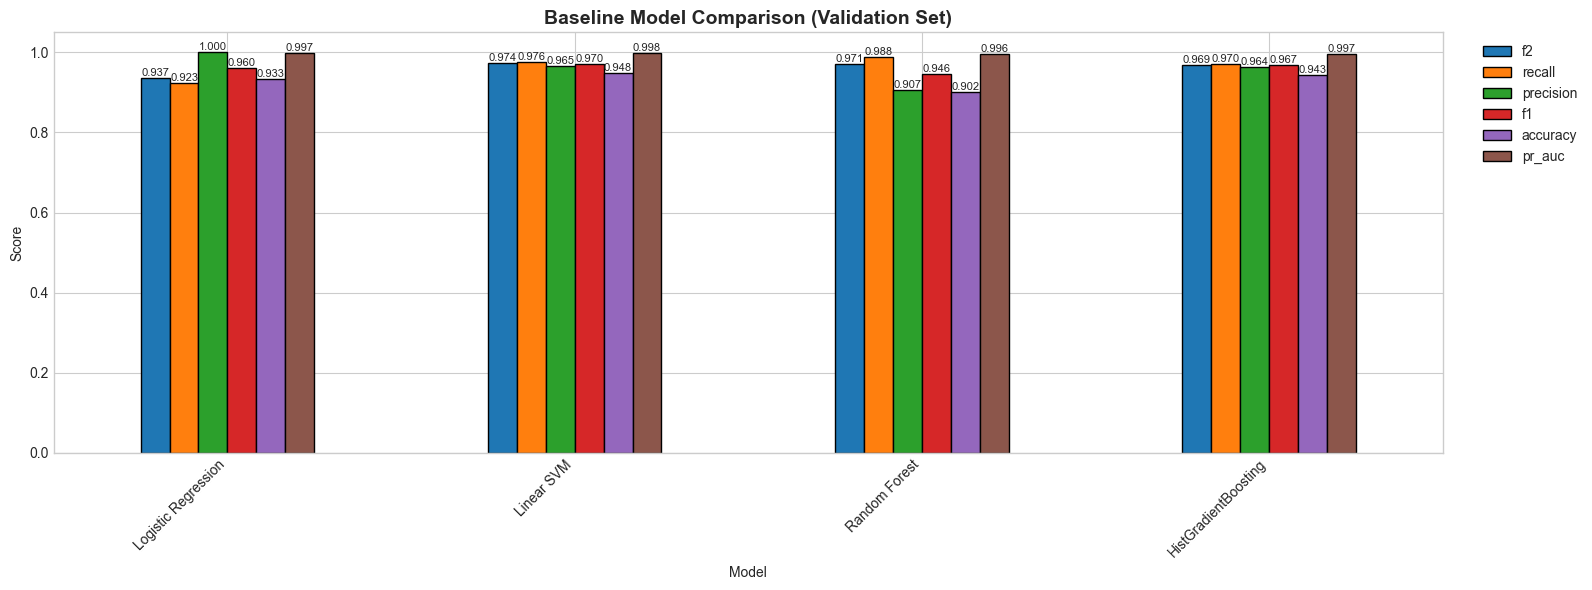

In [9]:
# Compare baseline models (with F2 as primary metric)
baseline_comparison = compare_models(
    baseline_results,
    metrics_to_display=['f2', 'recall', 'precision', 'f1', 'accuracy', 'pr_auc'],
    title='Baseline Model Comparison (Validation Set)',
    save_path='images/fp_baseline_comparison.png'
)

## 4. Hyperparameter Tuning

Tune the top-performing baseline models using cross-validation on train+val combined (80% of data). The test set remains completely held out for final evaluation.

### 4.1 Logistic Regression Tuning

In [10]:
# Logistic Regression parameter grid
lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'class_weight': ['balanced', None],
}

lr_search = create_search_object(
    search_type='grid',
    estimator=LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    param_grid=lr_param_grid,
    cv=cv,
    refit='f2'
)

lr_search, lr_log, lr_csv = tune_with_logging(
    lr_search, X_trainval, y_trainval,
    model_name='logistic_regression'
)


HYPERPARAMETER TUNING: logistic_regression
Total parameter combinations: 16
Cross-validation folds: 3
Total fits: 48
Log file: models/logs/logistic_regression_20251221_000916.log



Tuning complete!
Best score (f2): 0.9700
Results saved to: models/logs/logistic_regression_20251221_000916_cv_results.csv


### 4.2 Random Forest Tuning

In [11]:
# Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample'],
}

rf_search = create_search_object(
    search_type='grid',
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=cv,
    refit='f2'
)

rf_search, rf_log, rf_csv = tune_with_logging(
    rf_search, X_trainval, y_trainval,
    model_name='random_forest'
)


HYPERPARAMETER TUNING: random_forest
Total parameter combinations: 48
Cross-validation folds: 3
Total fits: 144
Log file: models/logs/random_forest_20251221_001013.log



/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning

/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning

/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning

/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning

/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning

Tuning complete!
Best score (f2): 0.9726
Results saved to: models/logs/random_forest_20251221_001013_cv_results.csv


### 4.3 HistGradientBoosting Tuning

In [12]:
# HistGradientBoosting parameter grid
# Note: Uses class_weight='balanced' for imbalanced data
hgb_param_grid = {
    'max_iter': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, None],
    'min_samples_leaf': [5, 20],
    'l2_regularization': [0.0, 0.1],
    'class_weight': ['balanced'],
}

hgb_search = create_search_object(
    search_type='grid',
    estimator=HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid=hgb_param_grid,
    cv=cv,
    refit='f2'
)

hgb_search, hgb_log, hgb_csv = tune_with_logging(
    hgb_search, X_trainval, y_trainval,
    model_name='hist_gradient_boosting'
)


HYPERPARAMETER TUNING: hist_gradient_boosting
Total parameter combinations: 48
Cross-validation folds: 3
Total fits: 144
Log file: models/logs/hist_gradient_boosting_20251221_001112.log



Tuning complete!
Best score (f2): 0.9648
Results saved to: models/logs/hist_gradient_boosting_20251221_001112_cv_results.csv


### 4.4 Compare Tuned Models (CV Performance)

Compare models based on their cross-validation F2 scores. Model selection is based on CV performance, not test set performance.

In [13]:
# Compare tuned models based on CV performance
tuned_models = {
    'LR_tuned': lr_search,
    'RF_tuned': rf_search,
    'HGB_tuned': hgb_search,
}

# Extract CV metrics for comparison
cv_comparison_data = []
for name, search in tuned_models.items():
    best_idx = search.best_index_
    cv_results = search.cv_results_
    
    metrics = {
        'model_name': name,
        'f2': cv_results['mean_test_f2'][best_idx],
        'recall': cv_results['mean_test_recall'][best_idx],
        'precision': cv_results['mean_test_precision'][best_idx],
        'f1': cv_results['mean_test_f1'][best_idx],
        'accuracy': cv_results['mean_test_accuracy'][best_idx],
        'pr_auc': cv_results['mean_test_average_precision'][best_idx],
    }
    cv_comparison_data.append(metrics)
    
    print(f"{name}: CV F2 = {metrics['f2']:.4f} (+/- {cv_results['std_test_f2'][best_idx]:.4f}), Recall = {metrics['recall']:.4f}, Precision = {metrics['precision']:.4f}")

LR_tuned: CV F2 = 0.9700 (+/- 0.0004), Recall = 1.0000, Precision = 0.8660
RF_tuned: CV F2 = 0.9726 (+/- 0.0039), Recall = 0.9940, Precision = 0.8957
HGB_tuned: CV F2 = 0.9648 (+/- 0.0083), Recall = 0.9717, Precision = 0.9386



Tuned Model Comparison (CV Performance, Optimized for F2)
                f2  recall  precision      f1  accuracy  pr_auc
model_name                                                     
LR_tuned    0.9700  1.0000     0.8660  0.9282    0.8660  0.8660
RF_tuned    0.9726  0.9940     0.8957  0.9422    0.8943  0.9941
HGB_tuned   0.9648  0.9717     0.9386  0.9548    0.9201  0.9938



Figure saved to images/fp_tuned_comparison.png


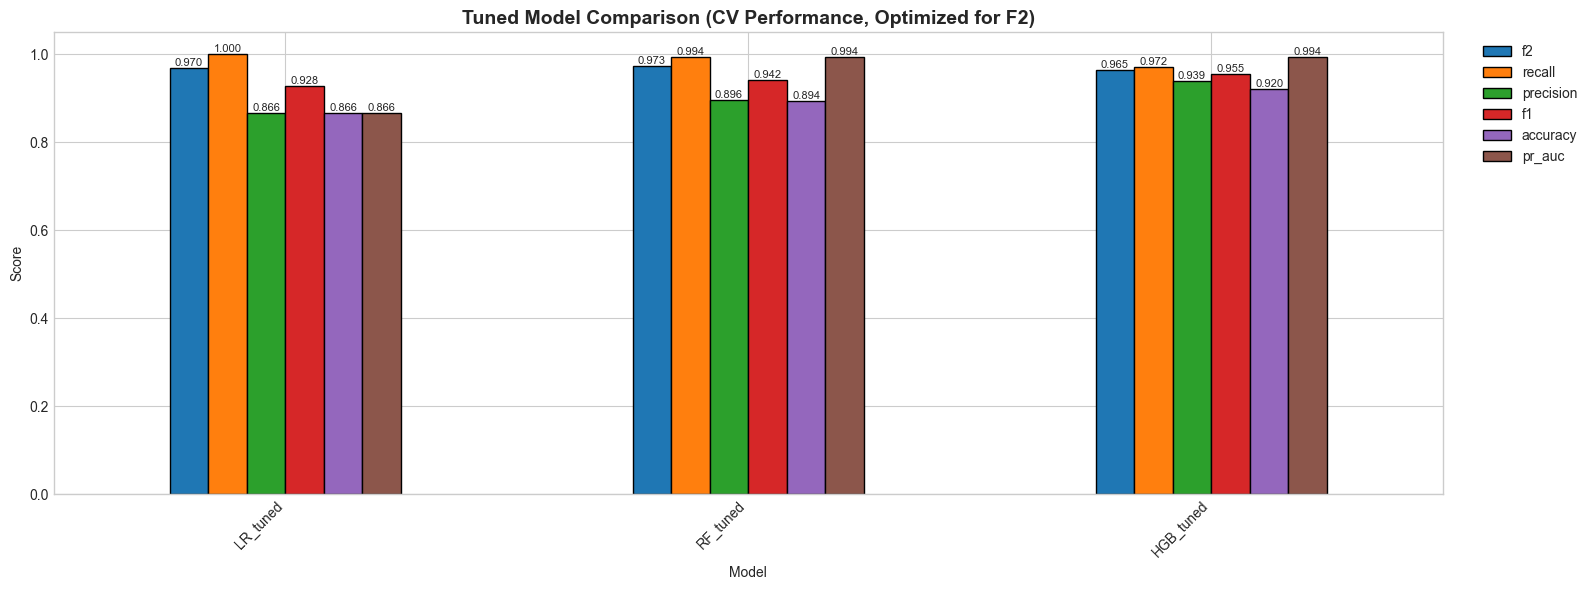

In [14]:
# Compare tuned models (F2 as primary metric)
tuned_comparison = compare_models(
    cv_comparison_data,
    metrics_to_display=['f2', 'recall', 'precision', 'f1', 'accuracy', 'pr_auc'],
    title='Tuned Model Comparison (CV Performance, Optimized for F2)',
    save_path='images/fp_tuned_comparison.png'
)

## 5. Overfitting Analysis

Analyze the gap between CV performance and test performance to assess model generalization.

In [15]:
# Evaluate all tuned models on test set and compare with CV performance
print("=" * 70)
print("OVERFITTING ANALYSIS: CV vs Test Performance")
print("=" * 70)

overfitting_data = []

for name, search in tuned_models.items():
    best_model = search.best_estimator_
    best_idx = search.best_index_
    cv_results = search.cv_results_
    
    # Get CV metrics
    cv_f2 = cv_results['mean_test_f2'][best_idx]
    cv_f2_std = cv_results['std_test_f2'][best_idx]
    cv_recall = cv_results['mean_test_recall'][best_idx]
    cv_precision = cv_results['mean_test_precision'][best_idx]
    
    # Get test metrics
    y_pred_test = best_model.predict(X_test)
    test_f2 = fbeta_score(y_test, y_pred_test, beta=2)
    test_recall = (y_pred_test[y_test == 1] == 1).mean()
    test_precision = (y_test[y_pred_test == 1] == 1).mean() if y_pred_test.sum() > 0 else 0
    
    # Calculate gaps
    f2_gap = test_f2 - cv_f2
    recall_gap = test_recall - cv_recall
    precision_gap = test_precision - cv_precision
    
    print(f"\n{name}:")
    print(f"  CV F2:       {cv_f2:.4f} (+/- {cv_f2_std:.4f})")
    print(f"  Test F2:     {test_f2:.4f}")
    print(f"  Gap:         {f2_gap:+.4f} {'⚠️ OVERFITTING' if f2_gap < -0.05 else '✓ OK'}")
    print(f"  CV Recall:   {cv_recall:.4f} | Test Recall:   {test_recall:.4f} | Gap: {recall_gap:+.4f}")
    print(f"  CV Precision:{cv_precision:.4f} | Test Precision:{test_precision:.4f} | Gap: {precision_gap:+.4f}")
    
    overfitting_data.append({
        'model': name,
        'cv_f2': cv_f2,
        'cv_f2_std': cv_f2_std,
        'test_f2': test_f2,
        'f2_gap': f2_gap,
        'cv_recall': cv_recall,
        'test_recall': test_recall,
        'cv_precision': cv_precision,
        'test_precision': test_precision,
    })

print("\n" + "=" * 70)

OVERFITTING ANALYSIS: CV vs Test Performance

LR_tuned:
  CV F2:       0.9700 (+/- 0.0004)
  Test F2:     0.9701
  Gap:         +0.0002 ✓ OK
  CV Recall:   1.0000 | Test Recall:   1.0000 | Gap: +0.0000
  CV Precision:0.8660 | Test Precision:0.8667 | Gap: +0.0007



RF_tuned:
  CV F2:       0.9726 (+/- 0.0039)
  Test F2:     0.9640
  Gap:         -0.0086 ✓ OK
  CV Recall:   0.9940 | Test Recall:   0.9822 | Gap: -0.0118
  CV Precision:0.8957 | Test Precision:0.8973 | Gap: +0.0016

HGB_tuned:
  CV F2:       0.9648 (+/- 0.0083)
  Test F2:     0.9694
  Gap:         +0.0046 ✓ OK
  CV Recall:   0.9717 | Test Recall:   0.9763 | Gap: +0.0046
  CV Precision:0.9386 | Test Precision:0.9429 | Gap: +0.0042



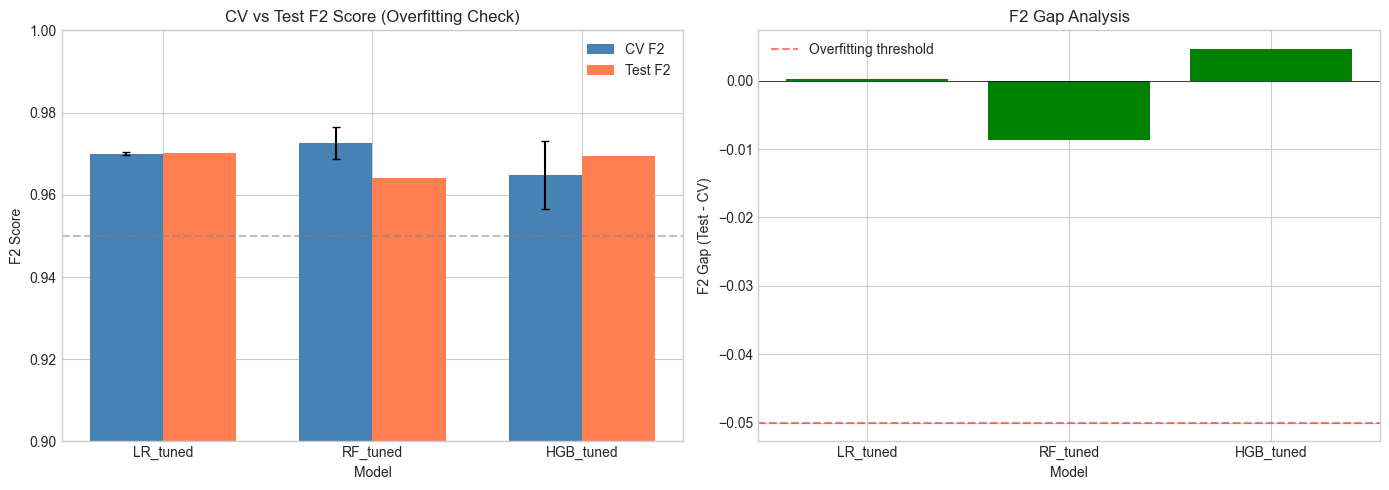

In [16]:
# Visualize CV vs Test performance
overfitting_df = pd.DataFrame(overfitting_data)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F2 comparison
ax1 = axes[0]
x = np.arange(len(overfitting_df))
width = 0.35
bars1 = ax1.bar(x - width/2, overfitting_df['cv_f2'], width, label='CV F2', color='steelblue')
bars2 = ax1.bar(x + width/2, overfitting_df['test_f2'], width, label='Test F2', color='coral')
ax1.errorbar(x - width/2, overfitting_df['cv_f2'], yerr=overfitting_df['cv_f2_std'], fmt='none', color='black', capsize=3)
ax1.set_xlabel('Model')
ax1.set_ylabel('F2 Score')
ax1.set_title('CV vs Test F2 Score (Overfitting Check)')
ax1.set_xticks(x)
ax1.set_xticklabels(overfitting_df['model'])
ax1.legend()
ax1.set_ylim([0.9, 1.0])
ax1.axhline(y=0.95, color='gray', linestyle='--', alpha=0.5, label='Threshold')

# Gap visualization
ax2 = axes[1]
colors = ['green' if gap >= -0.05 else 'red' for gap in overfitting_df['f2_gap']]
bars = ax2.bar(overfitting_df['model'], overfitting_df['f2_gap'], color=colors)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=-0.05, color='red', linestyle='--', alpha=0.5, label='Overfitting threshold')
ax2.set_xlabel('Model')
ax2.set_ylabel('F2 Gap (Test - CV)')
ax2.set_title('F2 Gap Analysis')
ax2.legend()

plt.tight_layout()
plt.savefig('images/fp_overfitting_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Final Model & Threshold Selection

Select the best model based on CV F2 score and evaluate on the held-out test set.

In [17]:
# Select best model based on CV F2
best_model_name, best_model_metrics = get_best_model(tuned_comparison, 'f2')
print(f"Selected model: {best_model_name}")
print(f"CV F2: {best_model_metrics['f2']:.4f} (primary metric)")
print(f"CV Recall: {best_model_metrics['recall']:.4f}")
print(f"CV Precision: {best_model_metrics['precision']:.4f}")


Best model by f2: RF_tuned
Score: 0.9726
Selected model: RF_tuned
CV F2: 0.9726 (primary metric)
CV Recall: 0.9940
CV Precision: 0.8957



MODEL EVALUATION: RF_tuned on Test

Classification Metrics:
  Accuracy:  0.8872
  Precision: 0.8973
  Recall:    0.9822
  F1 Score:  0.9379
  ROC-AUC:   0.9371
  PR-AUC:    0.9839

Confusion Matrix:
  TN: 7  FP: 19
  FN: 3  TP: 166

                precision    recall  f1-score   support

Not Sportswear       0.70      0.27      0.39        26
    Sportswear       0.90      0.98      0.94       169

      accuracy                           0.89       195
     macro avg       0.80      0.63      0.66       195
  weighted avg       0.87      0.89      0.86       195



Figure saved to images/fp_best_model_test.png


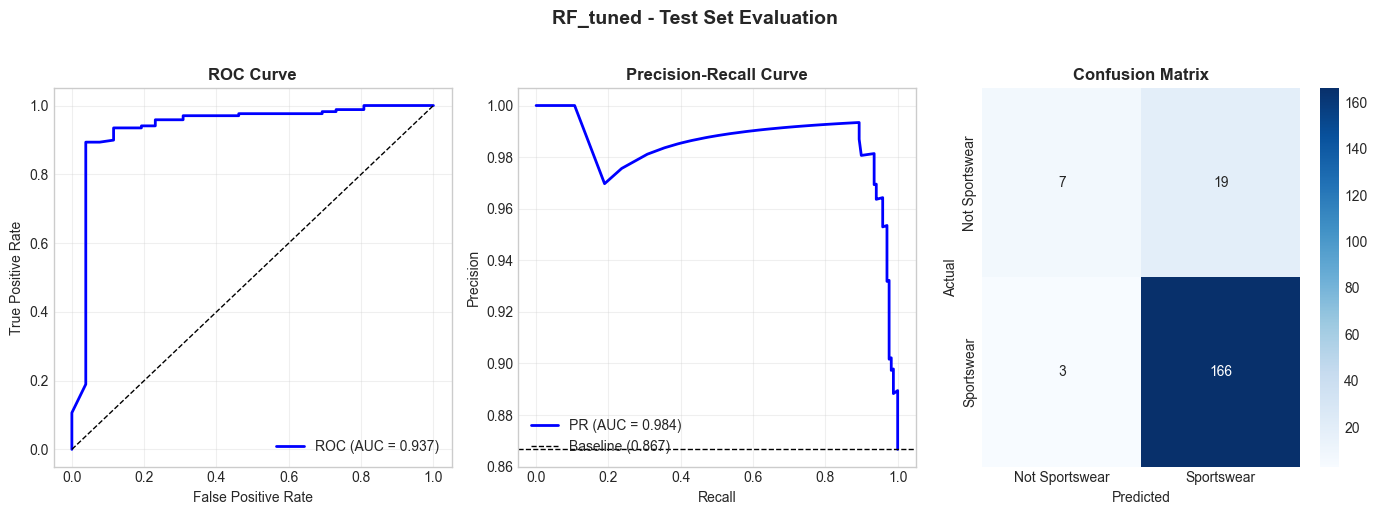

  F2 Score:  0.9640 (recall-weighted)


In [18]:
# Get the best model and evaluate on test set
best_search = tuned_models[best_model_name]
best_model = best_search.best_estimator_

# Evaluate on held-out test set (only once)
test_metrics = evaluate_model(
    best_model, X_test, y_test,
    model_name=best_model_name,
    dataset_name='Test',
    verbose=True,
    plot=True,
    save_path='images/fp_best_model_test.png'
)

# Add F2 score
y_pred_test = best_model.predict(X_test)
test_metrics['f2'] = fbeta_score(y_test, y_pred_test, beta=2)
print(f"  F2 Score:  {test_metrics['f2']:.4f} (recall-weighted)")

### 6.1 Threshold Tuning

Adjust the decision threshold to optimize recall at the cost of precision.

In [19]:
# Analyze precision-recall trade-off at different thresholds
y_proba = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Find thresholds for different target recall levels
target_recalls = [0.95, 0.97, 0.98, 0.99]

print("=" * 70)
print("THRESHOLD ANALYSIS: Recall vs Precision Trade-off")
print("=" * 70)
print("\nTarget Recall | Threshold | Actual Recall | Precision | FPs Passed")
print("-" * 70)

for target in target_recalls:
    idx = np.where(recalls >= target)[0]
    if len(idx) > 0:
        best_idx = idx[-1]
        threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.0
        actual_recall = recalls[best_idx]
        precision = precisions[best_idx]
        
        y_pred_custom = (y_proba >= threshold).astype(int)
        fp_count = ((y_pred_custom == 1) & (y_test == 0)).sum()
        total_fp = (y_test == 0).sum()
        
        print(f"    {target:.0%}      |   {threshold:.3f}   |    {actual_recall:.1%}      |   {precision:.1%}    |  {fp_count}/{total_fp}")

print("-" * 70)
print("\nLower threshold = Higher recall but more FPs pass to LLM")
print("=" * 70)

THRESHOLD ANALYSIS: Recall vs Precision Trade-off

Target Recall | Threshold | Actual Recall | Precision | FPs Passed
----------------------------------------------------------------------
    95%      |   0.740   |    95.3%      |   96.4%    |  6/26
    97%      |   0.675   |    97.0%      |   95.3%    |  8/26
    98%      |   0.530   |    98.2%      |   90.2%    |  18/26
    99%      |   0.445   |    99.4%      |   88.9%    |  21/26
----------------------------------------------------------------------

Lower threshold = Higher recall but more FPs pass to LLM


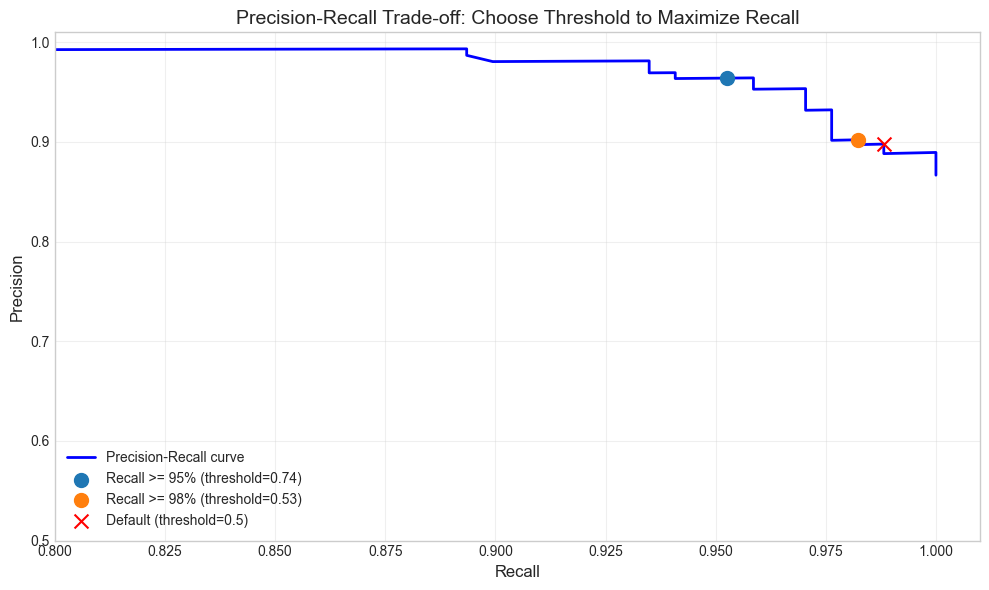

In [20]:
# Plot precision-recall curve with threshold markers
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(recalls, precisions, 'b-', linewidth=2, label='Precision-Recall curve')

# Mark key thresholds
for target in [0.95, 0.98]:
    idx = np.where(recalls >= target)[0]
    if len(idx) > 0:
        best_idx = idx[-1]
        ax.scatter(recalls[best_idx], precisions[best_idx], s=100, zorder=5,
                  label=f'Recall >= {target:.0%} (threshold={thresholds[best_idx]:.2f})')

# Mark default threshold (0.5)
default_idx = np.argmin(np.abs(thresholds - 0.5))
ax.scatter(recalls[default_idx], precisions[default_idx], s=100, c='red', marker='x', zorder=5,
          label=f'Default (threshold=0.5)')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Trade-off: Choose Threshold to Maximize Recall', fontsize=14)
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)
ax.set_xlim([0.8, 1.01])
ax.set_ylim([0.5, 1.01])

plt.tight_layout()
plt.savefig('images/fp_threshold_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# Set optimal threshold for deployment (targeting 98% recall)
TARGET_RECALL = 0.98
idx = np.where(recalls >= TARGET_RECALL)[0]
OPTIMAL_THRESHOLD = thresholds[idx[-1]] if len(idx) > 0 else 0.5

print("=" * 60)
print("OPTIMAL THRESHOLD FOR DEPLOYMENT")
print("=" * 60)
print(f"\nTarget recall: {TARGET_RECALL:.0%}")
print(f"Optimal threshold: {OPTIMAL_THRESHOLD:.4f}")

# Evaluate with optimal threshold
y_pred_optimal = (y_proba >= OPTIMAL_THRESHOLD).astype(int)
optimal_recall = (y_pred_optimal[y_test == 1] == 1).mean()
optimal_precision = (y_test[y_pred_optimal == 1] == 1).mean()
fp_passed = ((y_pred_optimal == 1) & (y_test == 0)).sum()
fn_missed = ((y_pred_optimal == 0) & (y_test == 1)).sum()

print(f"\nWith optimal threshold on test set:")
print(f"  Recall:    {optimal_recall:.4f} ({fn_missed} sportswear articles missed)")
print(f"  Precision: {optimal_precision:.4f} ({fp_passed} false positives passed to LLM)")
print("=" * 60)

OPTIMAL THRESHOLD FOR DEPLOYMENT

Target recall: 98%
Optimal threshold: 0.5301

With optimal threshold on test set:
  Recall:    0.9822 (3 sportswear articles missed)
  Precision: 0.9022 (18 false positives passed to LLM)


## 7. Export for Deployment

Save the complete pipeline (transformer + classifier) for Docker API deployment.

In [22]:
# Create complete pipeline for deployment
full_pipeline = Pipeline([
    ('features', transformer),
    ('classifier', best_model)
])

# Save complete pipeline
pipeline_path = MODELS_DIR / 'fp_classifier_pipeline.joblib'
joblib.dump(full_pipeline, pipeline_path)
print(f"Complete pipeline saved to {pipeline_path}")

# Save configuration
classifier_config = {
    'threshold': float(OPTIMAL_THRESHOLD),
    'target_recall': TARGET_RECALL,
    'transformer_method': transformer.method,
    'classifier_type': type(best_model).__name__,
    'cv_f2': float(best_model_metrics['f2']),
    'test_f2': float(test_metrics['f2']),
    'best_params': best_search.best_params_,
}

config_path = MODELS_DIR / 'fp_classifier_config.json'
with open(config_path, 'w') as f:
    json.dump(classifier_config, f, indent=2)
print(f"Configuration saved to {config_path}")

Complete pipeline saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_pipeline.joblib
Configuration saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_config.json


In [23]:
# Test the pipeline
print("Testing complete pipeline...")
test_texts = [
    "Nike announces new sustainability initiative to reduce carbon emissions",
    "Puma the wild cat was spotted in the mountains of Montana"
]

# Test predict
predictions = full_pipeline.predict(test_texts)
probabilities = full_pipeline.predict_proba(test_texts)[:, 1]

print("\nPipeline test results:")
for text, pred, prob in zip(test_texts, predictions, probabilities):
    label = "Sportswear" if pred == 1 else "False Positive"
    print(f"  [{prob:.4f}] {label}: {text[:60]}...")

Testing complete pipeline...

Pipeline test results:
  [0.9150] Sportswear: Nike announces new sustainability initiative to reduce carbo...
  [0.6200] Sportswear: Puma the wild cat was spotted in the mountains of Montana...


In [24]:
print("=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)
print(f"\nBest Model: {best_model_name}")
print(f"Feature Method: {transformer.method}")
print(f"\nCV Performance:")
print(f"  F2 Score:  {best_model_metrics['f2']:.4f}")
print(f"  Recall:    {best_model_metrics['recall']:.4f}")
print(f"  Precision: {best_model_metrics['precision']:.4f}")
print(f"\nTest Set Performance:")
print(f"  F2 Score:  {test_metrics['f2']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  F1 Score:  {test_metrics['f1']:.4f}")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  PR-AUC:    {test_metrics['pr_auc']:.4f}")
print(f"\nDeployment Threshold: {OPTIMAL_THRESHOLD:.4f}")
print(f"\nSaved Artifacts:")
print(f"  - {pipeline_path}")
print(f"  - {config_path}")
print("=" * 60)

FINAL RESULTS SUMMARY

Best Model: RF_tuned
Feature Method: sentence_transformer_ner

CV Performance:
  F2 Score:  0.9726
  Recall:    0.9940
  Precision: 0.8957

Test Set Performance:
  F2 Score:  0.9640
  Recall:    0.9822
  Precision: 0.8973
  F1 Score:  0.9379
  Accuracy:  0.8872
  PR-AUC:    0.9839

Deployment Threshold: 0.5301

Saved Artifacts:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_pipeline.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_classifier_config.json


## Next Steps

1. **Deploy Model**: Integrate `fp_classifier_pipeline.joblib` into Docker API service
2. **Monitor Performance**: Track F2/recall on new data to detect drift
3. **Retrain Periodically**: Update model as more labeled data becomes available
4. **Alternative FE Methods**: If performance degrades, explore sentence-transformers or doc2vec in fp1